In [49]:
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

In [50]:
input_file = "Assignment_3_files\Assignment 3 input data\input1.txt"
n_clusters = 8
eps = 15
minPts = 22

In [51]:
# Load the data from a text file
data = pd.read_csv(input_file, sep='\t', header=None, names=['object_id', 'x', 'y'])

# Convert the data into a 2D numpy array
X = data[['x', 'y']].values

In [70]:
# Define Euclidean distance function
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def cosine_dissimilarity(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def jaccard_dissimilarity(a, b):
    return 1 - np.sum(np.minimum(a, b)) / np.sum(np.maximum(a, b))

In [52]:
# Define range query function
def range_query(DB, distFunc, Q, eps):
    neighbors = []
    for P in range(len(DB)):
        if distFunc(DB[P], DB[Q]) < eps:
            neighbors.append(P)
    return neighbors

# Define DBSCAN function
def dbscan(DB, distFunc, eps, minPts):
    C = 0
    labels = [0]*len(DB)

    for P in range(len(DB)):
        if not (labels[P] == 0):
            continue
        neighbors = range_query(DB, distFunc, P, eps)
        if len(neighbors) < minPts:
            labels[P] = -1
            continue
        C += 1
        labels[P] = C
        seed_set = [n for n in neighbors if n != P]
        for Q in seed_set:
            if labels[Q] == -1:
                labels[Q] = C
            if labels[Q] != 0:
                continue
            labels[Q] = C
            neighbors = range_query(DB, distFunc, Q, eps)
            if len(neighbors) >= minPts:
                seed_set += neighbors
    return labels

In [53]:
labels = dbscan(X, euclidean_distance, eps, minPts)
labels

In [65]:
data['cluster'] = labels
data['object_id'] = data['object_id'].astype(str)
data.dtypes

object_id     object
x            float64
y            float64
cluster        int64
dtype: object

In [66]:
# Count number of points in each cluster
cluster_counts = Counter(labels)
print('Done cluster_counts: ', cluster_counts)

# # If there are more than n_clusters, remove the smallest ones
# if len(cluster_counts) > n_clusters:
#     smallest_clusters = [cluster for cluster, count in cluster_counts.most_common()[:-n_clusters-1:-1]]
#     labels = [label if label not in smallest_clusters else -1 for label in labels]

Done cluster_counts:  Counter({5: 1596, 2: 1593, 1: 1481, 3: 1458, 4: 1124, -1: 444, 6: 177, 8: 34, 9: 34, 7: 22, 11: 22, 10: 15})


In [68]:
# Create output directory if it doesn't exist
output_dir = os.path.splitext(input_file)[0]
os.makedirs(output_dir, exist_ok=True)
print('Done output_dir: ', output_dir)

# Output each cluster to a separate file
for cluster in set(labels):
    if cluster == -1:  # Skip noise points
        continue
    with open(f"{output_dir}_cluster_{cluster}.txt", 'w') as f:
        for i, label in enumerate(labels):
            if label == cluster:
                f.write(f"{data.iloc[i]['object_id']}\n")
    print('Done separate file: ', output_dir, cluster)

Done output_dir:  Assignment_3_files\Assignment 3 input data\input1
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 1
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 2
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 3
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 4
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 5
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 6
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 7
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 8
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 9
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 10
Done separate file:  Assignment_3_files\Assignment 3 input data\input1 11


C:\Users\DeRoxy\AppData\Local\Temp\ipykernel_14116\3633561759.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(data['cluster'].unique())-1)  # Get the 'viridis' colormap


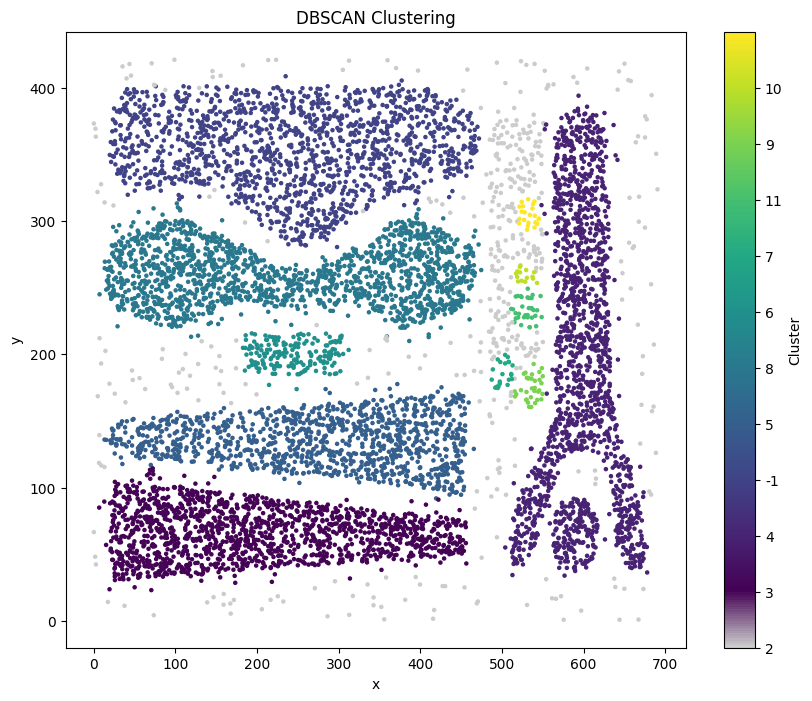

In [69]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a colormap
cmap = plt.cm.get_cmap('viridis', len(data['cluster'].unique())-1)  # Get the 'viridis' colormap
colors = cmap(np.arange(cmap.N))  # Get an array of colors from the colormap

# Add a gray color for noise (-1 cluster)
colors = np.vstack([[[0.8, 0.8, 0.8, 1]], colors])  # Stack a gray color at the beginning

# Create a new colormap with the gray color for noise
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)

# Ensure that 'cluster' column is categorical
data['cluster'] = data['cluster'].astype('category')

# Convert cluster to codes, add 1 to skip the gray color for noise
c = data['cluster'].cat.codes + 1

plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], c=c, cmap=cmap, s=5)  # Set s (size) to 20 to make points smaller

plt.title('DBSCAN Clustering')
plt.xlabel('x')
plt.ylabel('y')

# Create a colorbar as legend
cbar = plt.colorbar(ticks=range(len(data['cluster'].unique())))
cbar.set_label('Cluster')
cbar.set_ticklabels(data['cluster'].unique())

plt.show()
